# Emotion Detection
Tester: Muhammad Aditya Bayhaqie

[Reference](https://paperswithcode.com/paper/facial-emotion-recognition-state-of-the-art)

##Library Preparation

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import ReduceLROnPlateau

import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import os
import sys
import warnings
from sklearn.metrics import precision_score, f1_score, recall_score, confusion_matrix
import timm

warnings.filterwarnings("ignore")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Data Importing

In [2]:
data = pd.read_csv('/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv')

In [3]:
data.shape

(35887, 3)

In [4]:
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [5]:
np_data = np.array(data)

In [6]:
np_data.shape

(35887, 3)

In [7]:
np_data[0]

array([0, 'Training',
       '70 80 82 72 58 58 60 63 54 58 60 48 89 115 121 119 115 110 98 91 84 84 90 99 110 126 143 153 158 171 169 172 169 165 129 110 113 107 95 79 66 62 56 57 61 52 43 41 65 61 58 57 56 69 75 70 65 56 54 105 146 154 151 151 155 155 150 147 147 148 152 158 164 172 177 182 186 189 188 190 188 180 167 116 95 103 97 77 72 62 55 58 54 56 52 44 50 43 54 64 63 71 68 64 52 66 119 156 161 164 163 164 167 168 170 174 175 176 178 179 183 187 190 195 197 198 197 198 195 191 190 145 86 100 90 65 57 60 54 51 41 49 56 47 38 44 63 55 46 52 54 55 83 138 157 158 165 168 172 171 173 176 179 179 180 182 185 187 189 189 192 197 200 199 196 198 200 198 197 177 91 87 96 58 58 59 51 42 37 41 47 45 37 35 36 30 41 47 59 94 141 159 161 161 164 170 171 172 176 178 179 182 183 183 187 189 192 192 194 195 200 200 199 199 200 201 197 193 111 71 108 69 55 61 51 42 43 56 54 44 24 29 31 45 61 72 100 136 150 159 163 162 163 170 172 171 174 177 177 180 187 186 187 189 192 192 194 195 196 197 199 200

In [8]:
test_image = np_data[0][2].split()
print(type(test_image))
print(len(test_image))

<class 'list'>
2304


In [9]:
test_image = np.array(test_image).reshape(48, 48)
test_image.shape

(48, 48)

In [10]:
test_image = test_image.astype('float')

In [11]:
test_image

array([[ 70.,  80.,  82., ...,  52.,  43.,  41.],
       [ 65.,  61.,  58., ...,  56.,  52.,  44.],
       [ 50.,  43.,  54., ...,  49.,  56.,  47.],
       ...,
       [ 91.,  65.,  42., ...,  72.,  56.,  43.],
       [ 77.,  82.,  79., ..., 105.,  70.,  46.],
       [ 77.,  72.,  84., ..., 106., 109.,  82.]])

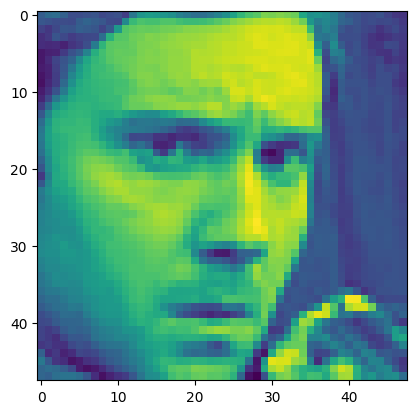

In [12]:
plt.imshow(test_image)

## Data Preparation

In [13]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None, augment=False):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.augment = augment

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img = np.array(self.images[idx])
        img = Image.fromarray(img)

        if self.transform:
            img = self.transform(img)

        label = torch.tensor(self.labels[idx]).type(torch.long)
        sample = (img, label)

        return sample

In [14]:
def fer2013_load_data(path='/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge/icml_face_data.csv'):
    fer2013 = pd.read_csv(path)
    emotion_mapping = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
    return fer2013, emotion_mapping

def fer2013_prepare_data(data):
    """ Prepare data for modeling
        input: data frame with labels und pixel data
        output: image and label array """

    # Add print statement to diagnose
    print("Columns in DataFrame received by fer2013_prepare_data:", data.columns)

    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label

# Modified fer2013_get_dataloaders to accept dataframe and use indices for filtering, and clean column names
def fer2013_get_dataloaders(data_df, bs=64, augment=True): # Accept DataFrame as input
    """ Prepare train, val, & test dataloaders
        Augment training data using:
            - cropping
            - shifting (vertical/horizental)
            - horizental flipping
            - rotation
    """
    # Use the provided data_df instead of loading internally
    fer2013 = data_df.copy() # Create a copy to avoid modifying the original DataFrame unintentionally
    emotion_mapping = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'} # Still need mapping

    # Clean column names by stripping leading/trailing whitespace
    fer2013.columns = fer2013.columns.str.strip()

    # Add print statement at the beginning of the function to see the received DataFrame columns after cleaning
    print("Columns in DataFrame received at start of fer2013_get_dataloaders (after cleaning):", fer2013.columns)


    if 'Usage' not in fer2013.columns: # Check for cleaned column name
         raise KeyError("The 'Usage' column is missing from the provided DataFrame after cleaning.")

    # Get indices for each usage type using the cleaned column name
    train_indices = fer2013[fer2013['Usage'] == 'Training'].index
    val_indices = fer2013[fer2013['Usage'] == 'PrivateTest'].index
    test_indices = fer2013[fer2013['Usage'] == 'PublicTest'].index


    # Use indices to select data when calling fer2013_prepare_data
    xtrain, ytrain = fer2013_prepare_data(fer2013.loc[train_indices])
    xval, yval = fer2013_prepare_data(fer2013.loc[val_indices])
    xtest, ytest = fer2013_prepare_data(fer2013.loc[test_indices])


    mu, st = 0, 255

    test_transform = transforms.Compose([
        transforms.TenCrop(40),
        transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
        transforms.Lambda(lambda tensors: torch.stack([transforms.Normalize(mean=(mu,), std=(st,))(t) for t in tensors])),
    ])

    if augment:
        train_transform = transforms.Compose([
            transforms.RandomResizedCrop(48, scale=(0.8, 1.2)),
            transforms.RandomApply([transforms.RandomAffine(0, translate=(0.2, 0.2))], p=0.5),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([transforms.RandomRotation(10)], p=0.5),
            transforms.TenCrop(40),
            transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
            transforms.Lambda(lambda tensors: torch.stack([transforms.Normalize(mean=(mu,), std=(st,))(t) for t in tensors])),
            transforms.Lambda(lambda tensors: torch.stack([transforms.RandomErasing(p=0.5)(t) for t in tensors])),
        ])
    else:
        train_transform = test_transform

    train = CustomDataset(xtrain, ytrain, train_transform)
    val = CustomDataset(xval, yval, test_transform)
    test = CustomDataset(xtest, ytest, test_transform)

    trainloader = DataLoader(train, batch_size=bs, shuffle=True)
    valloader = DataLoader(val, batch_size=64, shuffle=True)
    testloader = DataLoader(test, batch_size=64, shuffle=True)

    return trainloader, valloader, testloader

## Model Development

### VGG

In [15]:
class VggFeatures(nn.Module):
    def __init__(self, drop=0.2):
        super().__init__()
        self.conv1a = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.conv1b = nn.Conv2d(64, out_channels=64, kernel_size=3, padding=1)
        self.conv2a = nn.Conv2d(64, 128, 3, padding=1)
        self.conv2b = nn.Conv2d(128, 128, 3, padding=1)
        self.conv3a = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3b = nn.Conv2d(256, 256, 3, padding=1)
        self.conv4a = nn.Conv2d(256, 512, 3, padding=1)
        self.conv4b = nn.Conv2d(512, 512, 3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn1a = nn.BatchNorm2d(64)
        self.bn1b = nn.BatchNorm2d(64)
        self.bn2a = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(128)
        self.bn3a = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)
        self.bn4a = nn.BatchNorm2d(512)
        self.bn4b = nn.BatchNorm2d(512)
        self.lin1 = nn.Linear(512 * 2 * 2, 4096)
        self.lin2 = nn.Linear(4096, 4096)
        self.drop = nn.Dropout(p=drop)

    def forward(self, x):
        x = F.relu(self.bn1a(self.conv1a(x)))
        x = F.relu(self.bn1b(self.conv1b(x)))
        x = self.pool(x)
        x = F.relu(self.bn2a(self.conv2a(x)))
        x = F.relu(self.bn2b(self.conv2b(x)))
        x = self.pool(x)
        x = F.relu(self.bn3a(self.conv3a(x)))
        x = F.relu(self.bn3b(self.conv3b(x)))
        x = self.pool(x)
        x = F.relu(self.bn4a(self.conv4a(x)))
        x = F.relu(self.bn4b(self.conv4b(x)))
        x = self.pool(x)
        x = x.view(-1, 512 * 2 * 2)
        x = F.relu(self.drop(self.lin1(x)))
        x = F.relu(self.drop(self.lin2(x)))
        return x

class Vgg(VggFeatures):
    def __init__(self, drop=0.2):
        super().__init__(drop)
        self.lin3 = nn.Linear(4096, 7)

    def forward(self, x):
        x = super().forward(x)
        x = self.lin3(x)
        return x

### EfficientNet

In [16]:
class EfficientNet(nn.Module):
    def __init__(self, pretrained=True, drop=0.1):
        super().__init__()
        self.model = timm.create_model('tf_efficientnet_b3_ns', pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, 7)

    def forward(self, x):
        x = x.repeat(1, 3, 1, 1)
        x = self.model(x)
        return x

## Model Fine-Tuning

### Logger

In [17]:
class Logger:
    def __init__(self):
        self.loss_train = []
        self.loss_val = []
        self.acc_train = []
        self.acc_val = []

    def get_logs(self):
        return self.loss_train, self.loss_val, self.acc_train, self.acc_val

    def restore_logs(self, logs):
        self.loss_train, self.loss_val, self.acc_train, self.acc_val = logs

    def save_plt(self, hps):
        loss_path = os.path.join(hps['model_save_dir'], 'loss.jpg')
        acc_path = os.path.join(hps['model_save_dir'], 'acc.jpg')

        plt.figure()
        plt.plot(self.acc_train, 'g', label='Training Acc')
        plt.plot(self.acc_val, 'b', label='Validation Acc')
        plt.title('Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Acc')
        plt.legend()
        plt.grid()
        plt.savefig(acc_path)

        plt.figure()
        plt.plot(self.loss_train, 'g', label='Training Loss')
        plt.plot(self.loss_val, 'b', label='Validation Loss')
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid()
        plt.savefig(loss_path)

### Hyperparameters

In [18]:
def setup_hparams(args):
    hps = {
        'network': '', 'name': '', 'n_epochs': 300, 'model_save_dir': None,
        'restore_epoch': None, 'start_epoch': 0, 'lr': 0.01,
        'save_freq': 20, 'drop': 0.1, 'bs': 64,
    }
    possible_nets = ['vgg', 'efn'] # Simplified for notebook

    for arg in args:
        key, value = arg.split('=', 1)
        if key in hps:
            # Type casting for notebook environment
            if key in ['n_epochs', 'start_epoch', 'save_freq', 'bs', 'restore_epoch']:
                hps[key] = int(value) if value is not None and value != 'None' else None
            elif key in ['lr', 'drop']:
                hps[key] = float(value)
            else:
                hps[key] = value
        else:
            raise ValueError(f'{key} is not a valid hyper parameter')

    if hps['network'] not in possible_nets:
        raise ValueError(f"Invalid network. Possible ones include: {possible_nets}")

    if hps['restore_epoch']:
        hps['start_epoch'] = hps['restore_epoch']

    hps['model_save_dir'] = os.path.join(os.getcwd(), 'checkpoints', hps['name'])
    if not os.path.exists(hps['model_save_dir']):
        os.makedirs(hps['model_save_dir'])

    return hps

### Checkpoints

In [19]:
def save_checkpoint(net, logger, hps, epoch):
    path = os.path.join(hps['model_save_dir'], f'epoch_{epoch}')
    checkpoint = {'logs': logger.get_logs(), 'params': net.state_dict()}
    torch.save(checkpoint, path)

def restore_checkpoint(net, logger, hps):
    """Load back the model and logger from a given checkpoint."""
    if hps['restore_epoch'] is None:
        print("No restore epoch provided. Training from scratch.")
        hps['start_epoch'] = 0
        return

    path = os.path.join(hps['model_save_dir'], f"epoch_{hps['restore_epoch']}")
    if os.path.exists(path):
        try:
            checkpoint = torch.load(path, map_location=device)
            logger.restore_logs(checkpoint['logs'])
            net.load_state_dict(checkpoint['params'])
            print(f"Network Restored from epoch {hps['restore_epoch']}!")
        except Exception as e:
            print(f"Restore Failed! {e}. Training from scratch.")
            hps['start_epoch'] = 0
    else:
        print("Restore point unavailable. Training from scratch.")
        hps['start_epoch'] = 0

### Network Setups

In [20]:
def setup_network(hps):
    nets = {'vgg': Vgg, 'efn': EfficientNet}
    net = nets[hps['network']]()
    logger = Logger()
    restore_checkpoint(net, logger, hps)
    return logger, net

## Model Execution & Evaluation

In [21]:
def train_loop(net, dataloader, criterion, optimizer, scaler, Ncrop=True):
    net = net.train()
    loss_tr, correct_count, n_samples = 0.0, 0.0, 0.0

    for i, data in enumerate(dataloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        with autocast():
            if Ncrop:
                bs, ncrops, c, h, w = inputs.shape
                inputs = inputs.view(-1, c, h, w)
                labels = torch.repeat_interleave(labels, repeats=ncrops, dim=0)

            outputs = net(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        loss_tr += loss.item()
        _, preds = torch.max(outputs.data, 1)
        correct_count += (preds == labels).sum().item()
        n_samples += labels.size(0)

    acc = 100 * correct_count / n_samples
    loss = loss_tr / n_samples
    return acc, loss

def evaluate_loop(net, dataloader, criterion, Ncrop=True):
    net = net.eval()
    loss_tr, correct_count, n_samples = 0.0, 0.0, 0.0
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            if Ncrop:
                bs, ncrops, c, h, w = inputs.shape
                inputs = inputs.view(-1, c, h, w)
                outputs = net(inputs)
                outputs = outputs.view(bs, ncrops, -1)
                outputs = torch.sum(outputs, dim=1) / ncrops
            else:
                outputs = net(inputs)

            loss = criterion(outputs, labels)
            loss_tr += loss.item()
            _, preds = torch.max(outputs.data, 1)
            correct_count += (preds == labels).sum().item()
            n_samples += labels.size(0)

    acc = 100 * correct_count / n_samples
    loss = loss_tr / n_samples
    return acc, loss

No restore epoch provided. Training from scratch.
Columns in DataFrame received at start of fer2013_get_dataloaders (after cleaning): Index(['emotion', 'Usage', 'pixels'], dtype='object')
Columns in DataFrame received by fer2013_prepare_data: Index(['emotion', 'Usage', 'pixels'], dtype='object')
Columns in DataFrame received by fer2013_prepare_data: Index(['emotion', 'Usage', 'pixels'], dtype='object')
Columns in DataFrame received by fer2013_prepare_data: Index(['emotion', 'Usage', 'pixels'], dtype='object')
Training my_vgg_run on cuda:0
** New best validation accuracy: 51.0449%. Checkpoint saved. **
Epoch  1		Train Accuracy: 33.8991 %		Val Accuracy: 51.0449 %
** New best validation accuracy: 53.1346%. Checkpoint saved. **
Epoch  2		Train Accuracy: 48.1299 %		Val Accuracy: 53.1346 %
** New best validation accuracy: 59.2644%. Checkpoint saved. **
Epoch  3		Train Accuracy: 52.7908 %		Val Accuracy: 59.2644 %
** New best validation accuracy: 61.2705%. Checkpoint saved. **
Epoch  4		Train 

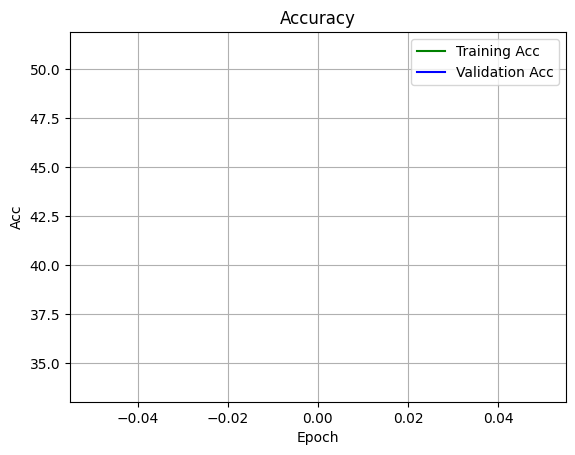

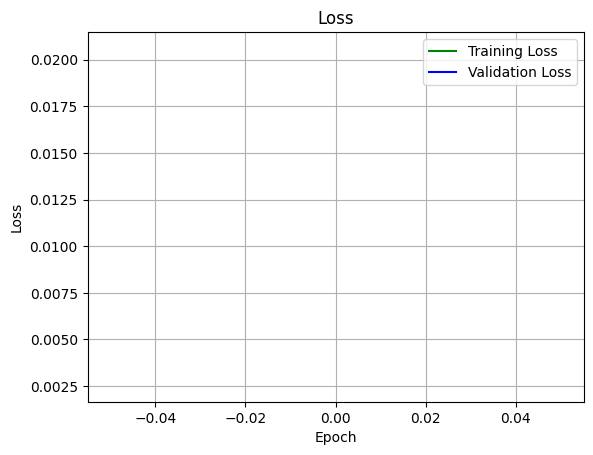

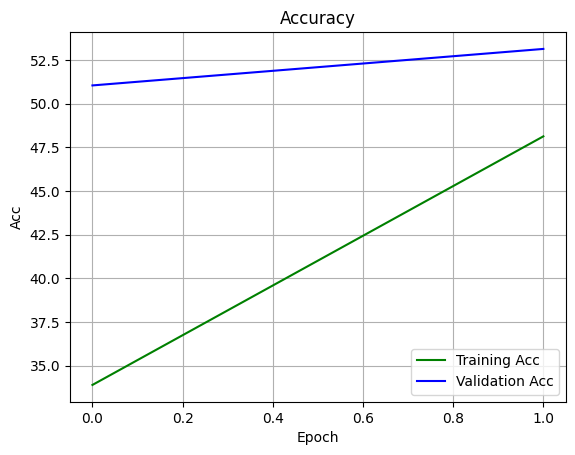

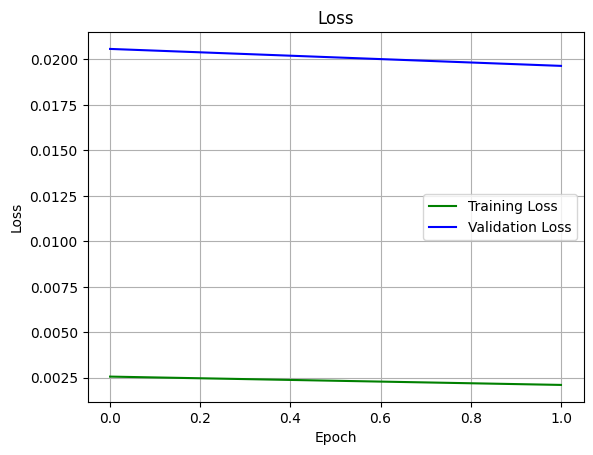

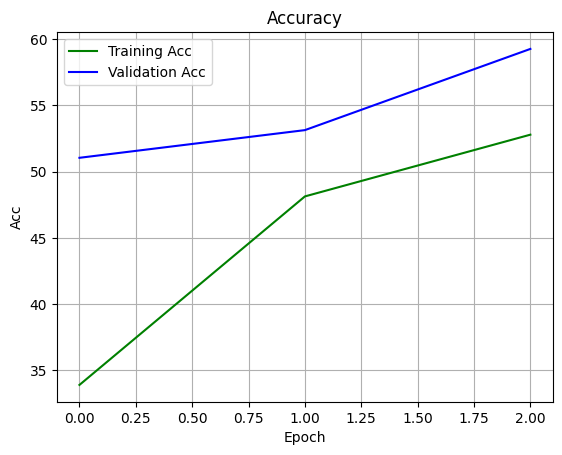

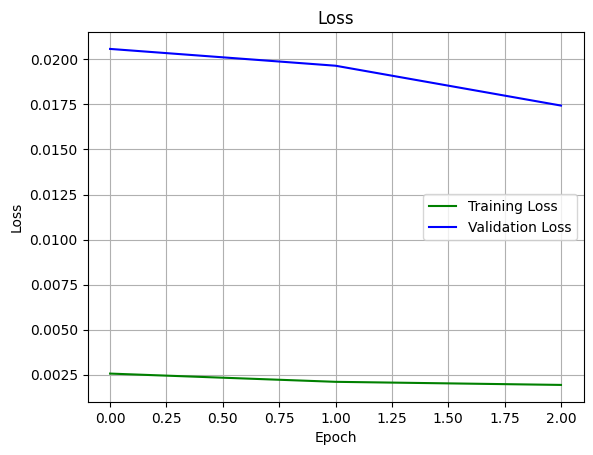

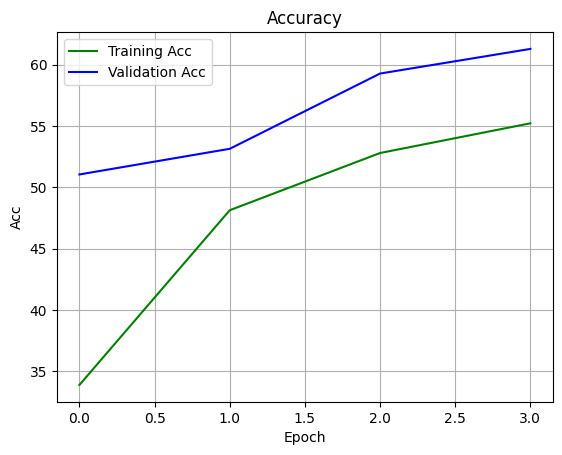

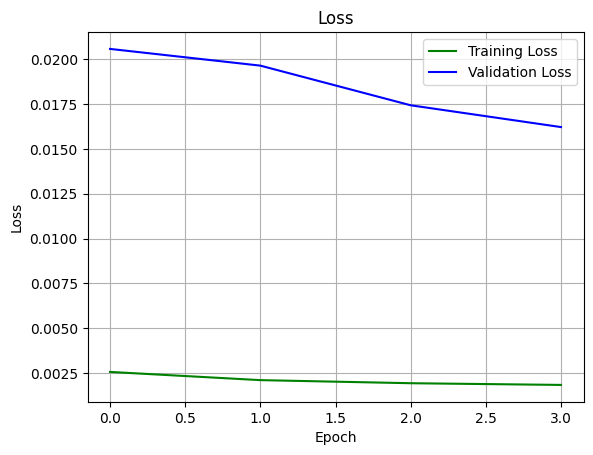

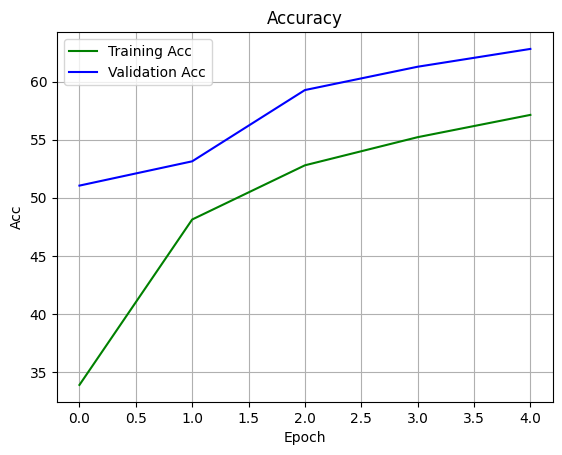

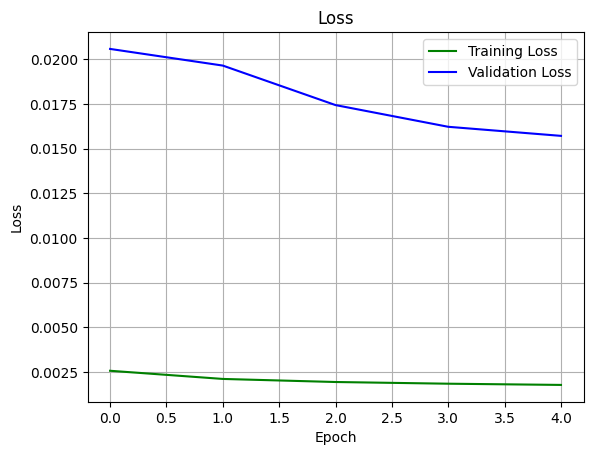

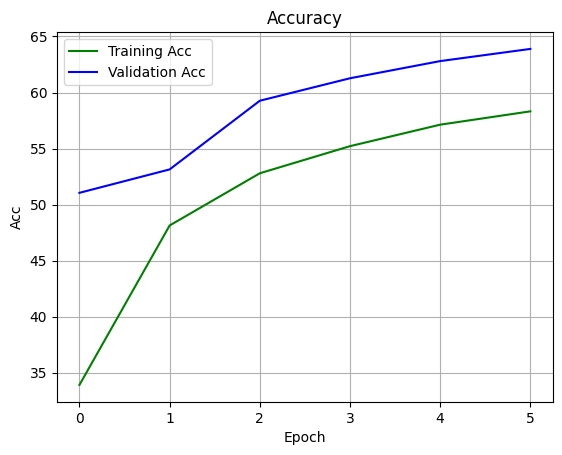

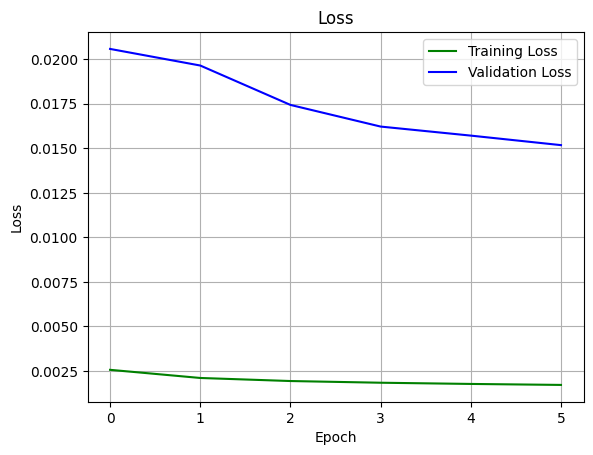

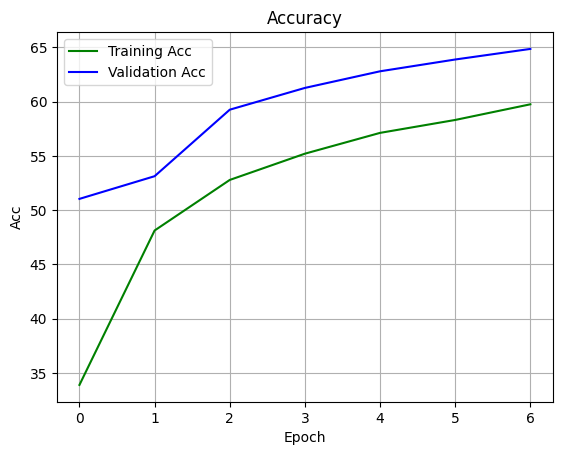

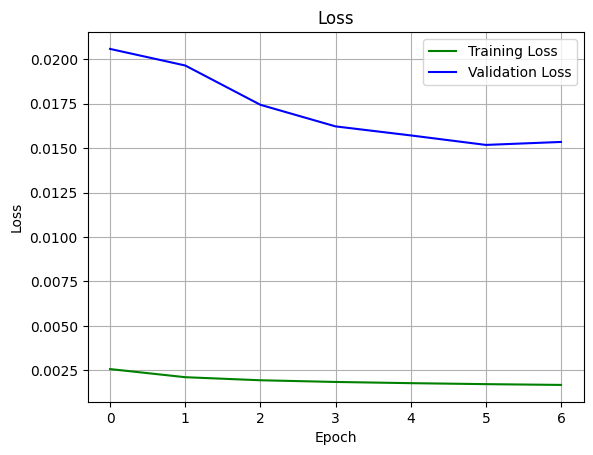

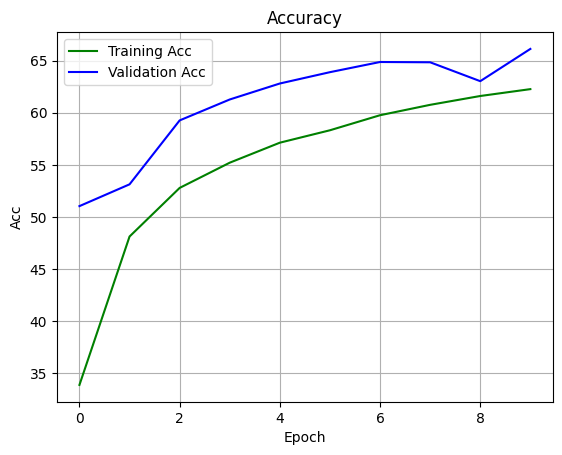

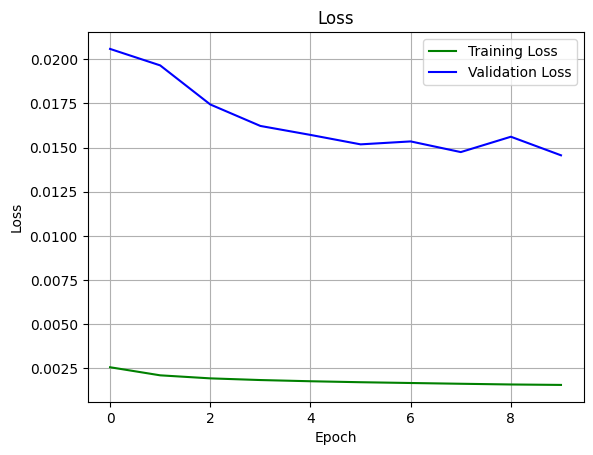

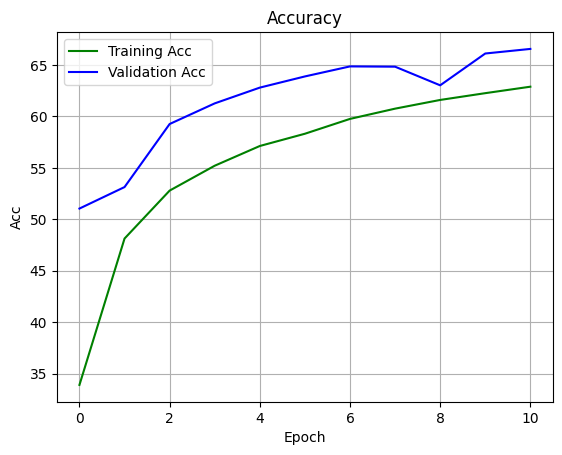

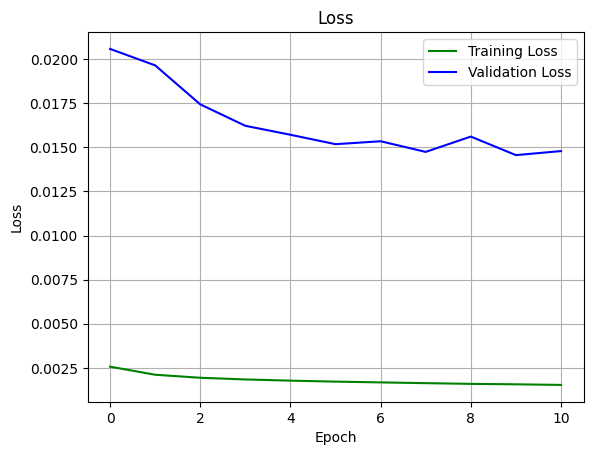

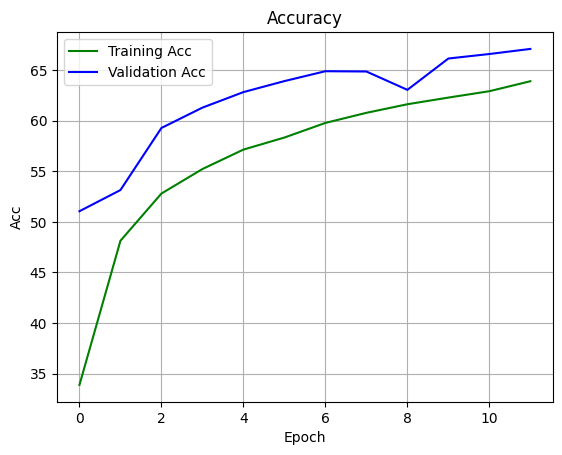

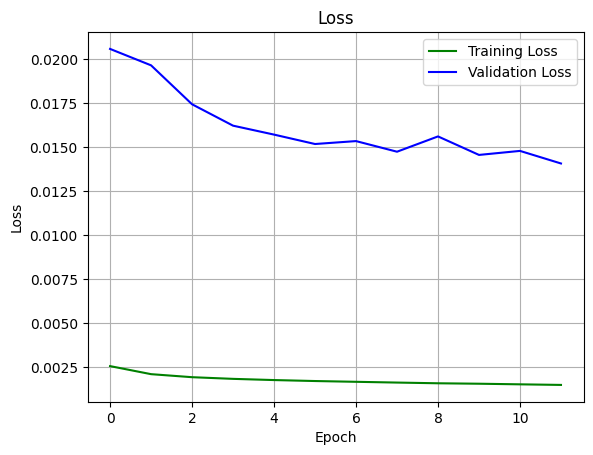

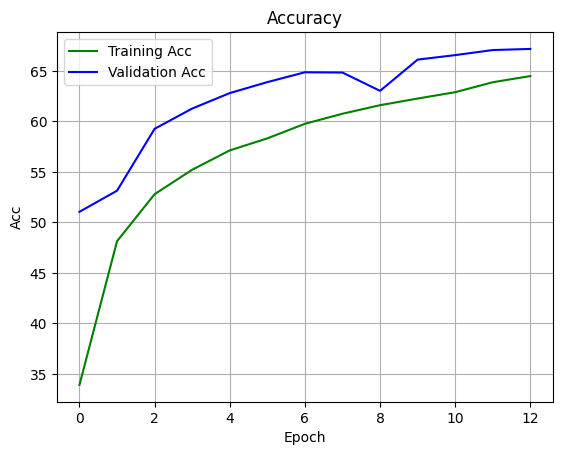

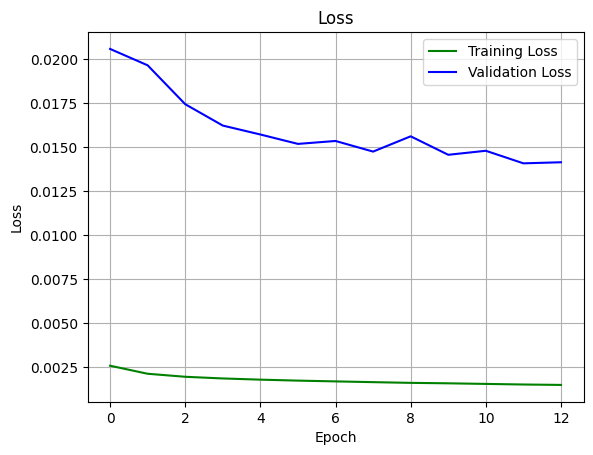

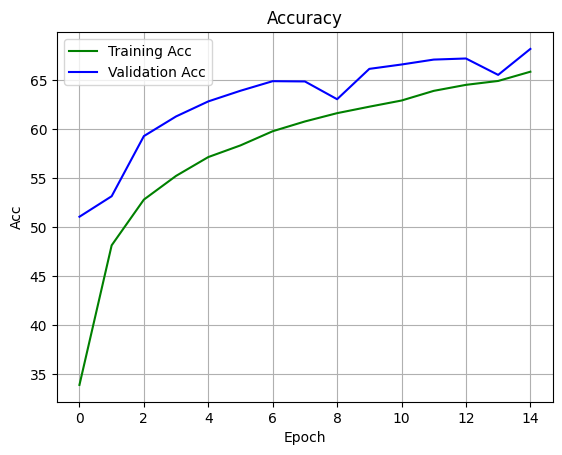

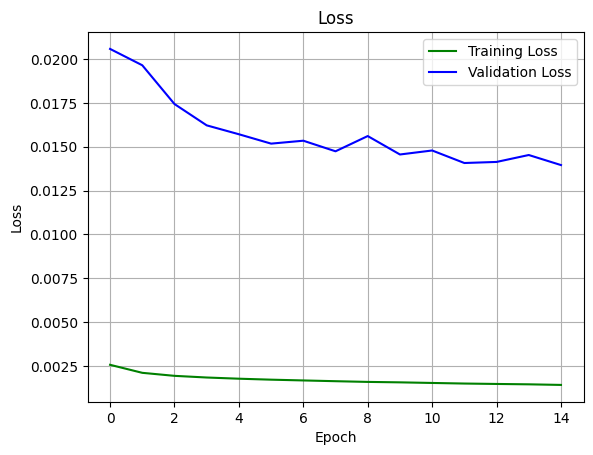

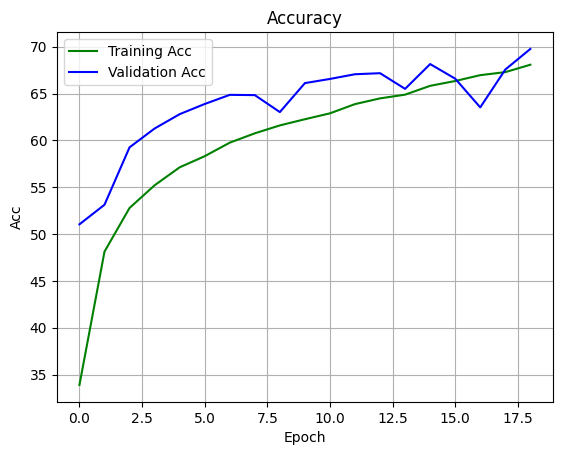

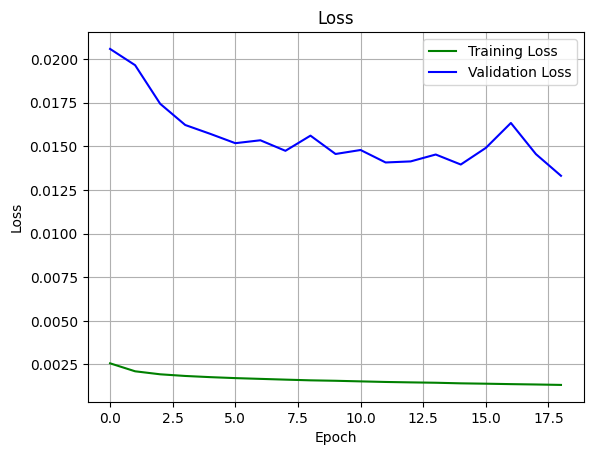

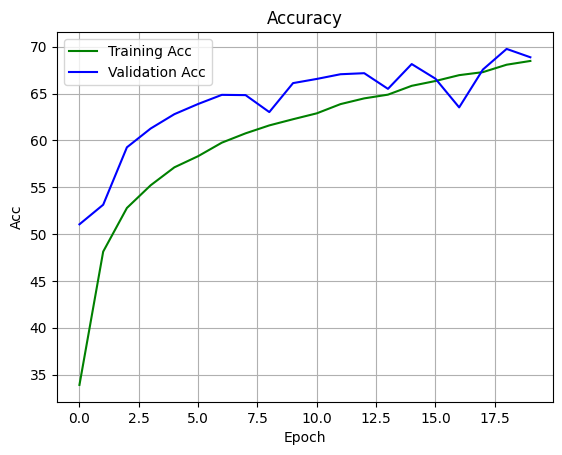

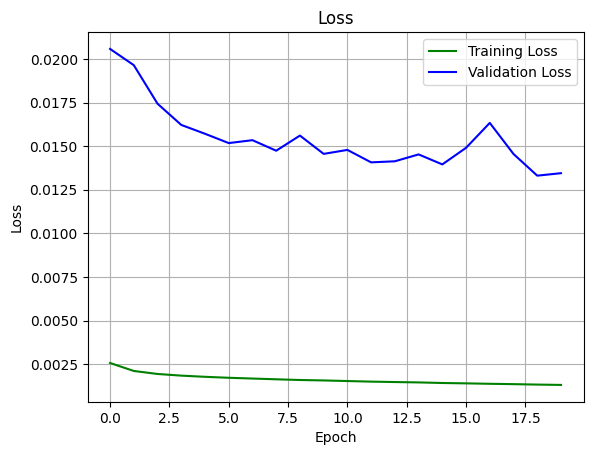

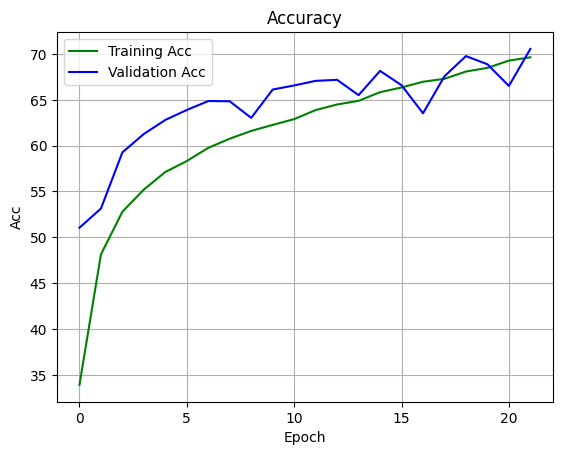

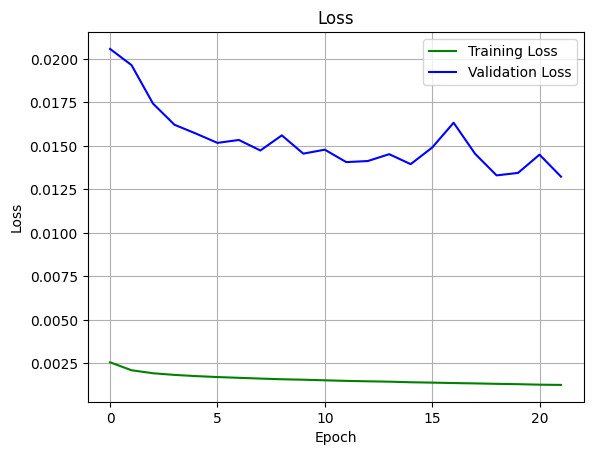

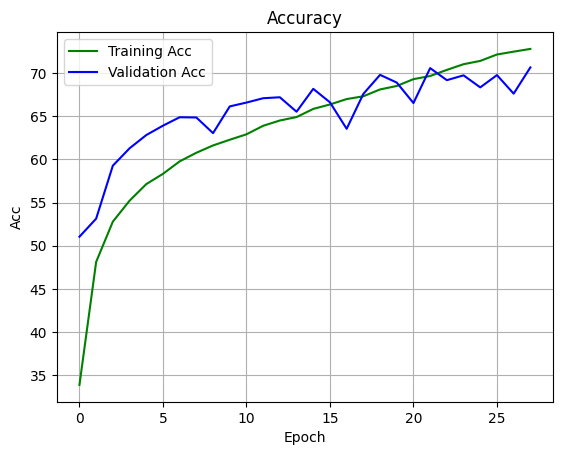

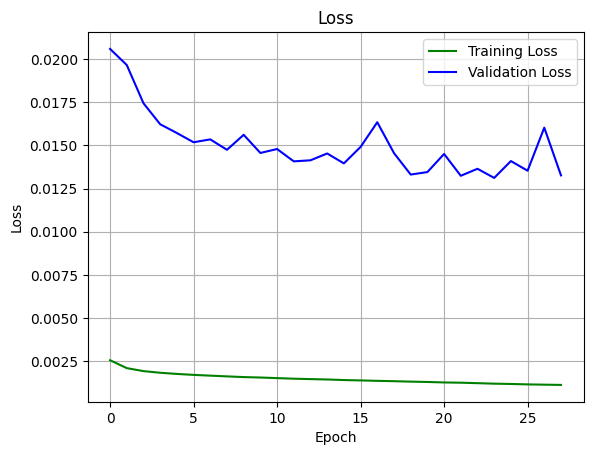

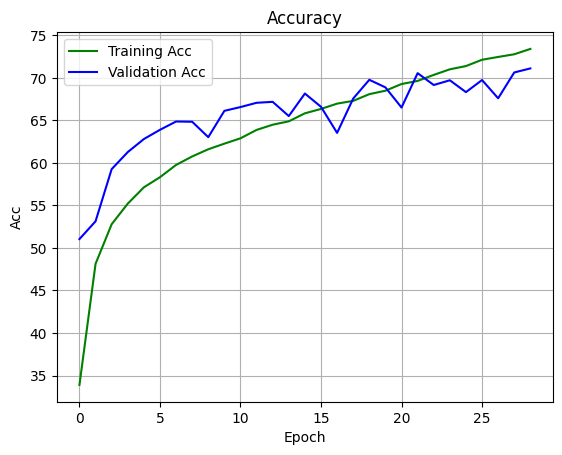

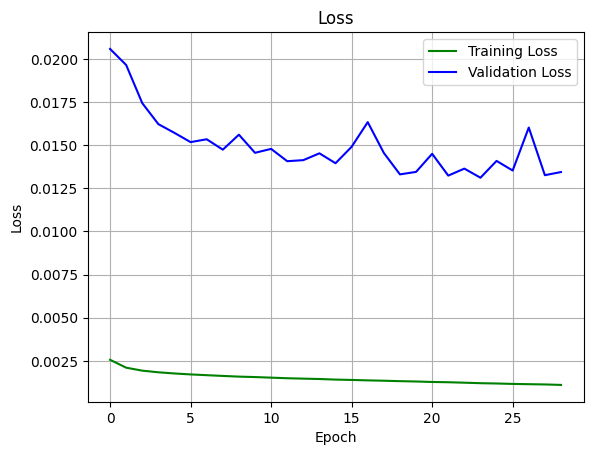

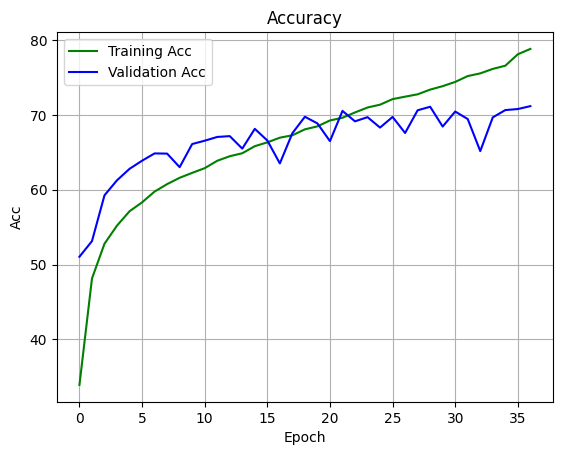

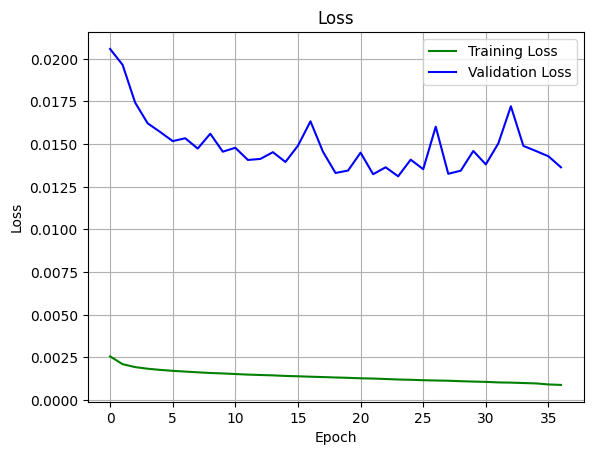

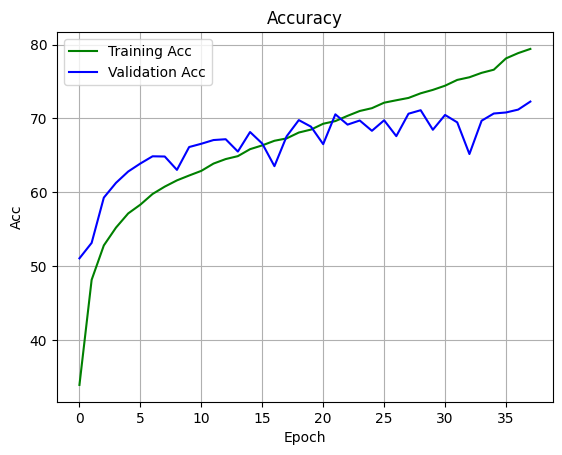

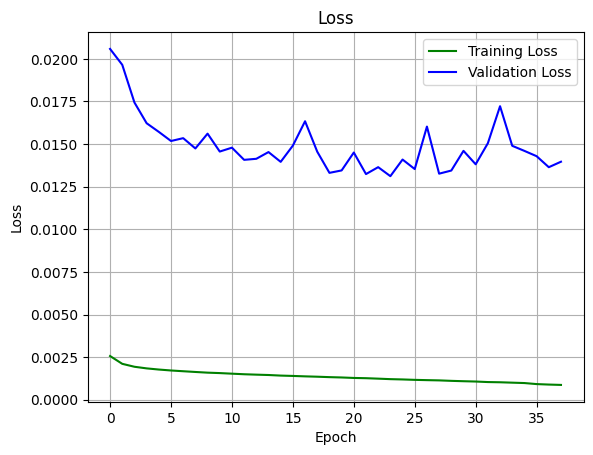

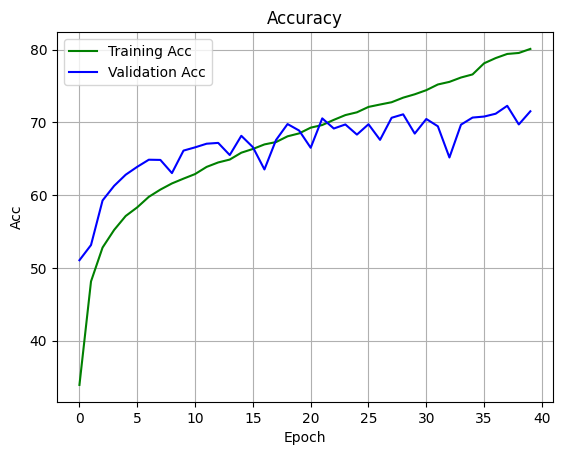

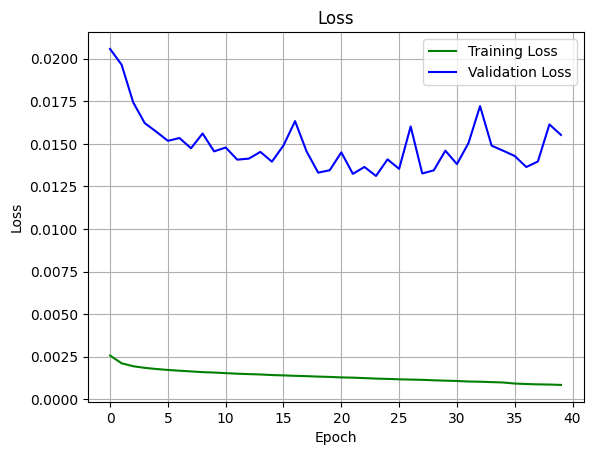

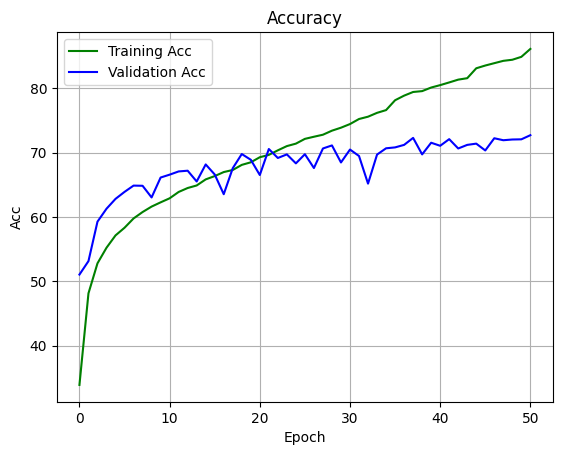

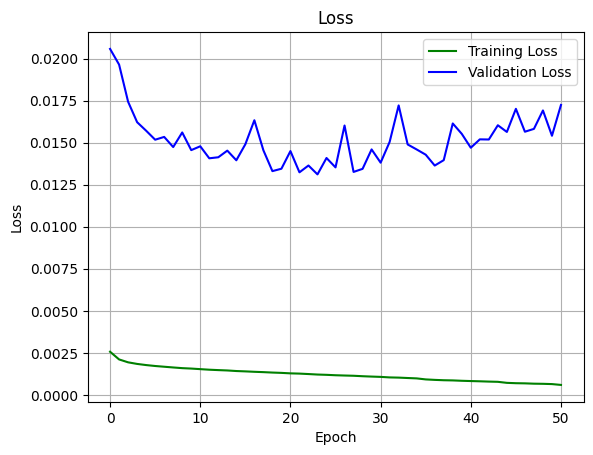

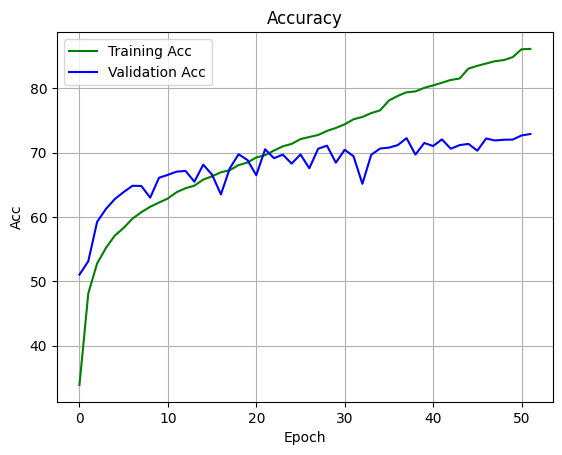

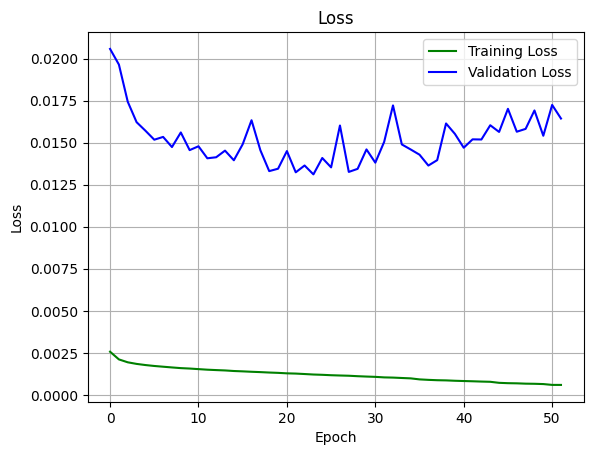

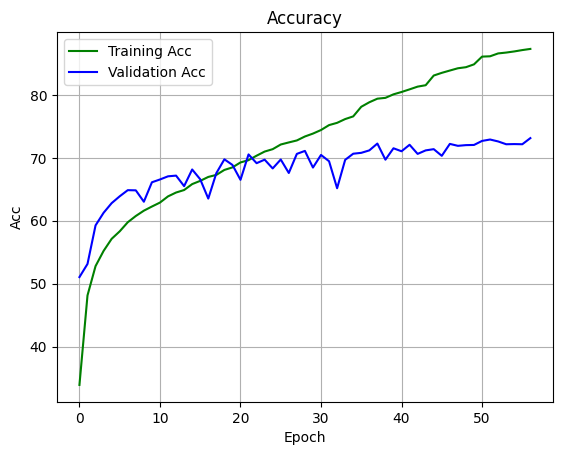

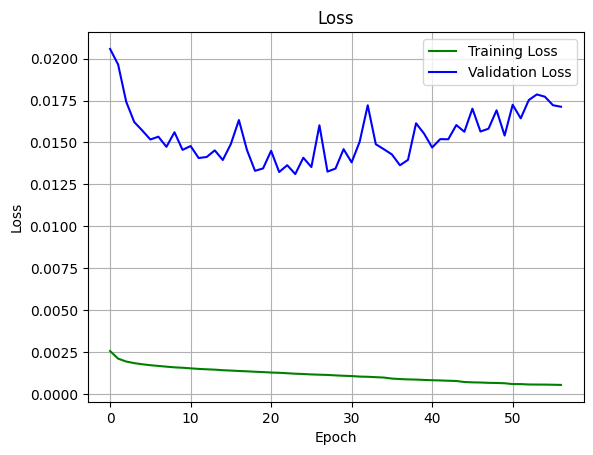

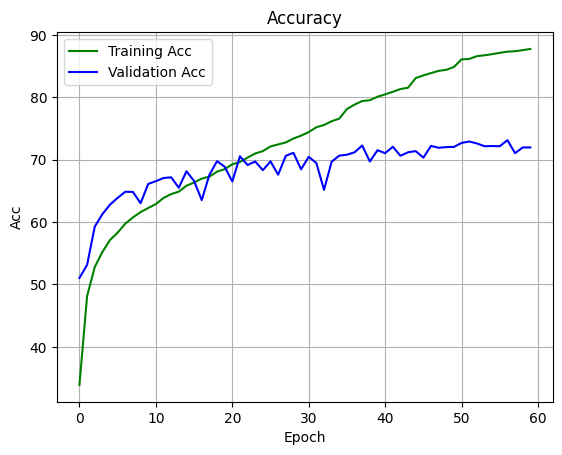

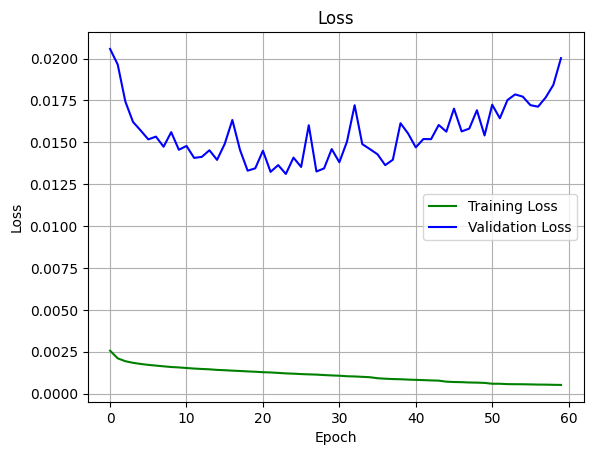

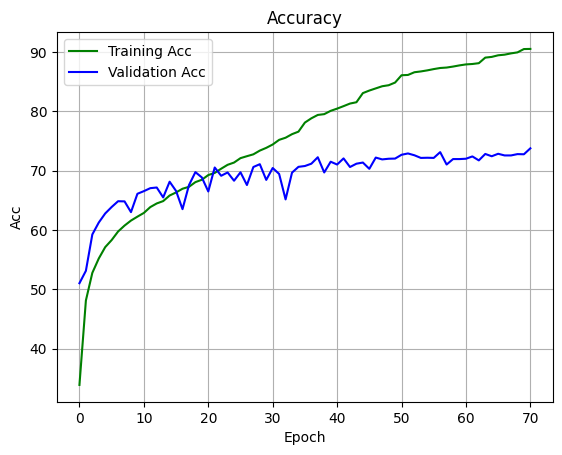

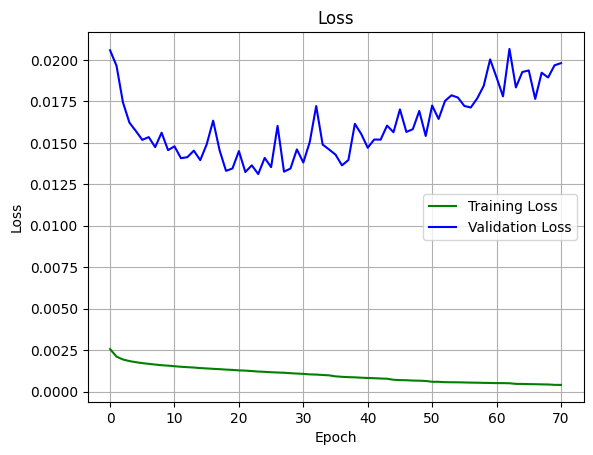

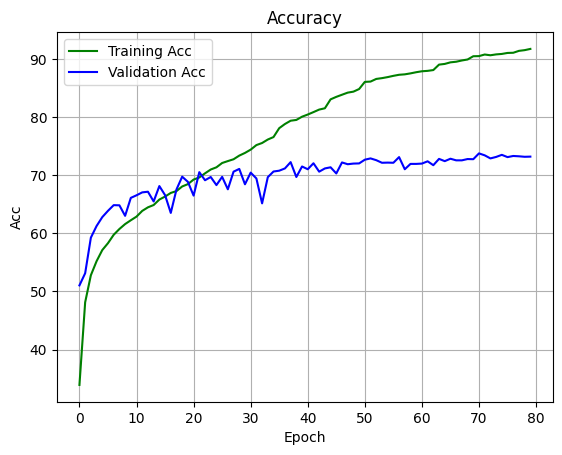

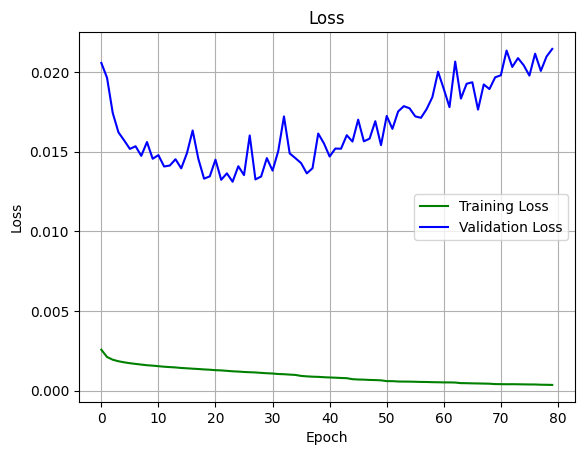

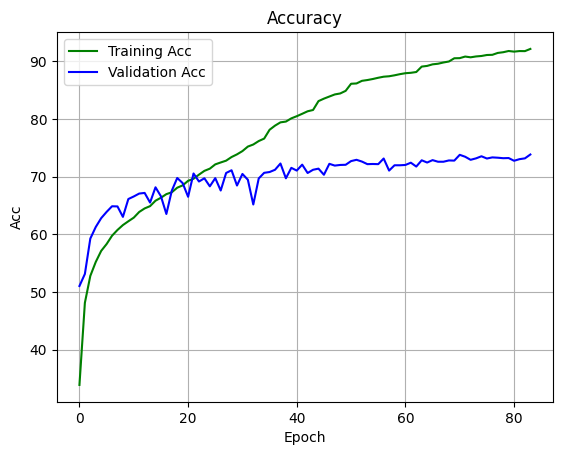

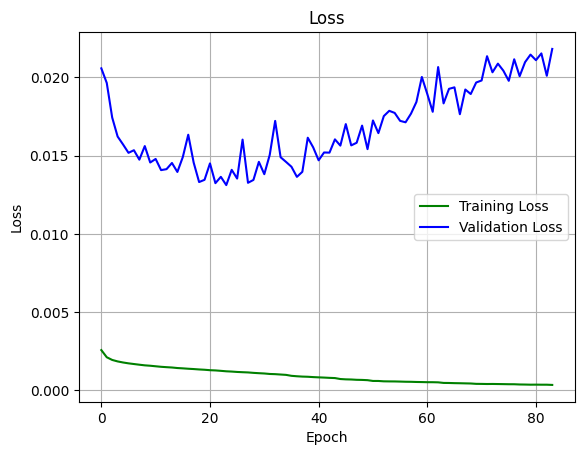

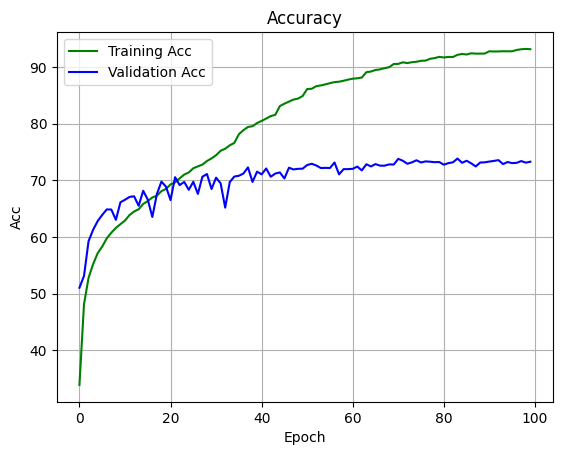

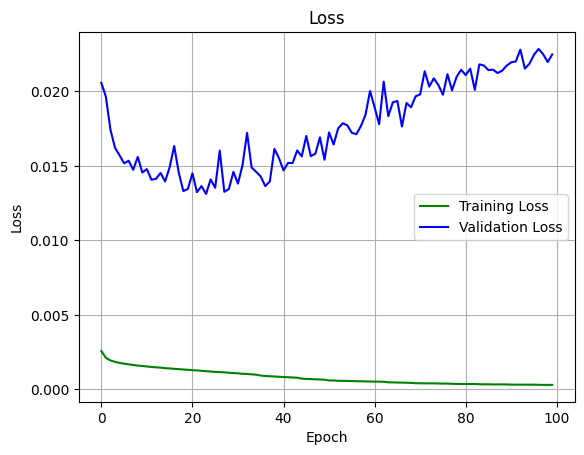

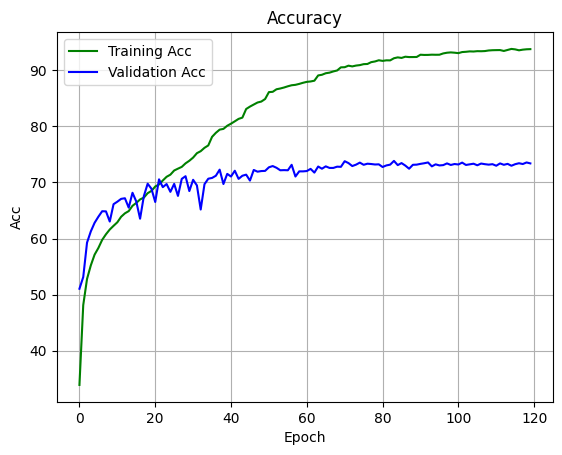

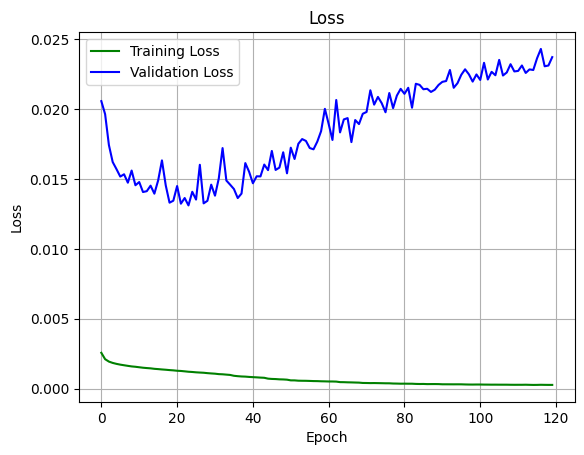

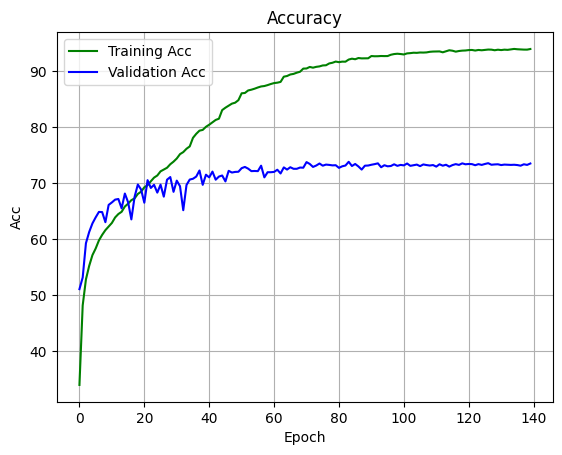

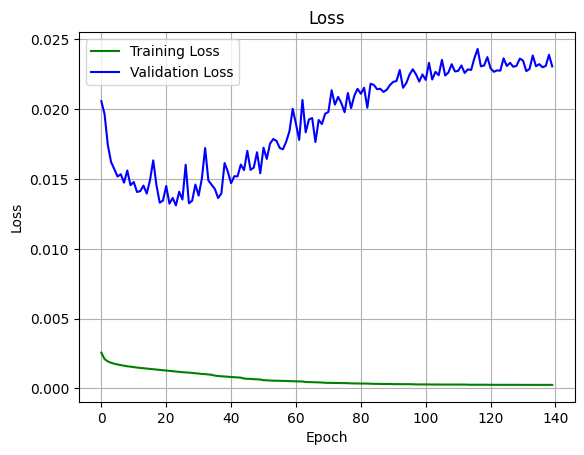

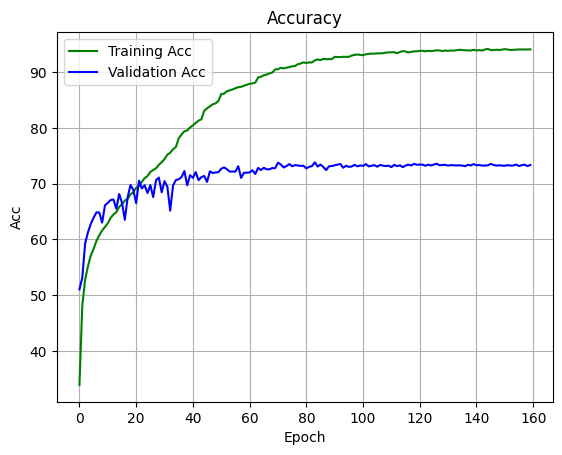

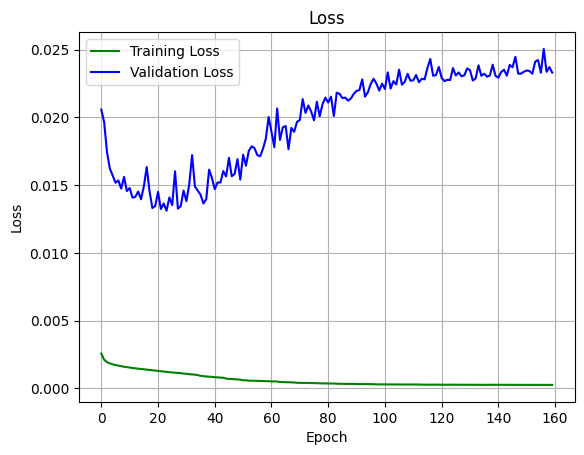

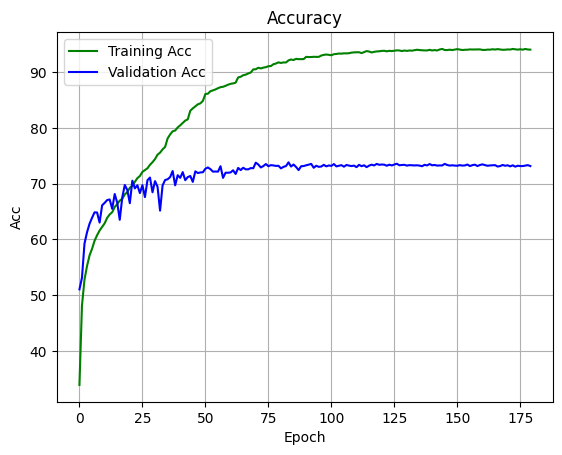

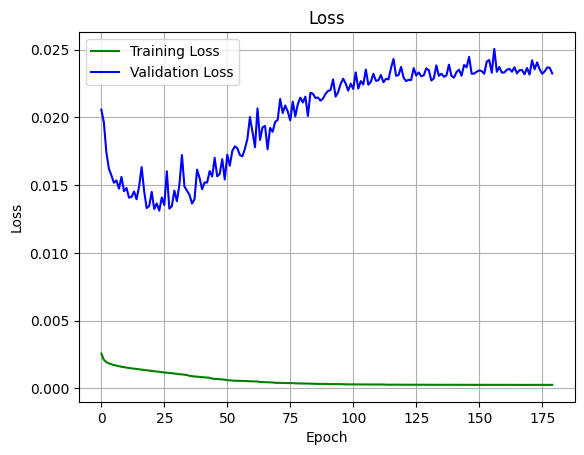

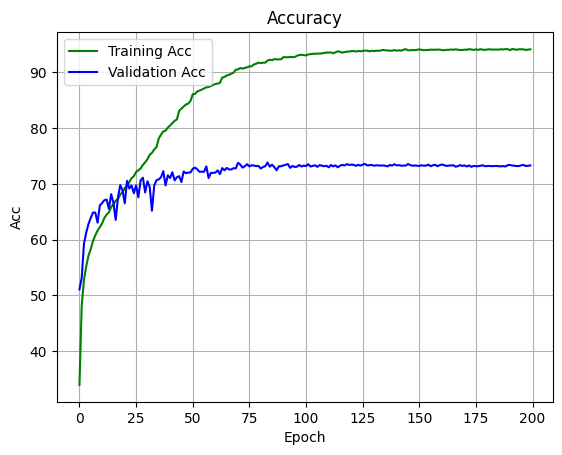

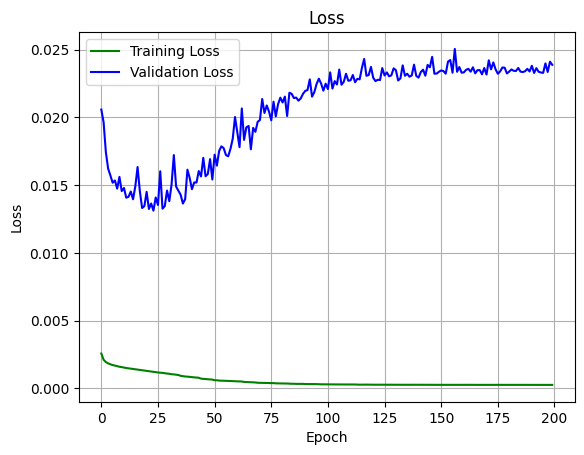

In [22]:
def run_training(hps_args):
    hps = setup_hparams(hps_args)
    logger, net = setup_network(hps)

    # Pass the globally available 'data' DataFrame
    trainloader, valloader, testloader = fer2013_get_dataloaders(data, bs=hps['bs'])
    net = net.to(device)
    scaler = GradScaler()
    optimizer = torch.optim.SGD(net.parameters(), lr=hps['lr'], momentum=0.9, nesterov=True, weight_decay=0.0001)
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.75, patience=5, verbose=True)
    criterion = nn.CrossEntropyLoss()
    best_acc = 0.0

    print(f"Training {hps['name']} on {device}")
    for epoch in range(hps['start_epoch'], hps['n_epochs']):
        acc_tr, loss_tr = train_loop(net, trainloader, criterion, optimizer, scaler)
        logger.loss_train.append(loss_tr)
        logger.acc_train.append(acc_tr)

        acc_v, loss_v = evaluate_loop(net, valloader, criterion)
        logger.loss_val.append(loss_v)
        logger.acc_val.append(acc_v)

        scheduler.step(acc_v)

        if acc_v > best_acc:
            best_acc = acc_v
            save_checkpoint(net, logger, hps, epoch + 1)
            logger.save_plt(hps)
            print(f"** New best validation accuracy: {best_acc:.4f}%. Checkpoint saved. **")

        if (epoch + 1) % hps['save_freq'] == 0:
            save_checkpoint(net, logger, hps, epoch + 1)
            logger.save_plt(hps)

        print(f"Epoch {epoch + 1:2d}\t\tTrain Accuracy: {acc_tr:2.4f} %"
              f"\t\tVal Accuracy: {acc_v:2.4f} %")

    acc_test, loss_test = evaluate_loop(net, testloader, criterion)
    print(f"Test Accuracy: {acc_test:2.4f} %\t\tTest Loss: {loss_test:2.6f}")

hps_args = ['network=vgg', 'name=my_vgg_run', 'n_epochs=200', 'bs=64']
run_training(hps_args)

In [23]:
def correct_count_topk(output, target, topk=(1,)):
    """Computes the top k correct count for the specified values of k"""
    maxk = max(topk)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    res = []
    for k in topk:
        correct_k = correct[:k].contiguous().view(-1).float().sum(0, keepdim=True)
        res.append(correct_k)
    return res

# Modified run_evaluation to accept data_df
def run_evaluation(hps_args, data_df): # Accept data_df as argument
    hps = setup_hparams(hps_args)
    logger, net = setup_network(hps)
    net = net.to(device)
    criterion = nn.CrossEntropyLoss()

    # Get data with no augmentation for fair evaluation
    # Use the provided data_df
    _, _, testloader = fer2013_get_dataloaders(data_df, augment=False) # Pass the received data_df

    net.eval()
    loss_tr, n_samples = 0.0, 0.0
    y_pred, y_gt = [], []
    correct_count1, correct_count2 = 0, 0

    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            bs, ncrops, c, h, w = inputs.shape
            inputs = inputs.view(-1, c, h, w)
            outputs = net(inputs)
            outputs = outputs.view(bs, ncrops, -1)
            outputs = torch.sum(outputs, dim=1) / ncrops
            loss = criterion(outputs, labels)

            loss_tr += loss.item()
            counts = correct_count_topk(outputs, labels, topk=(1, 2))
            correct_count1 += counts[0].item()
            correct_count2 += counts[1].item()
            _, preds = torch.max(outputs.data, 1)

            y_pred.extend(p.item() for p in preds.cpu())
            y_gt.extend(l.item() for l in labels.cpu())
            n_samples += labels.size(0)

    acc1 = 100 * correct_count1 / n_samples
    acc2 = 100 * correct_count2 / n_samples
    loss = loss_tr / n_samples

    print("----------------- Test Set Evaluation -----------------")
    print(f"Top 1 Accuracy: {acc1:.6f} %")
    print(f"Top 2 Accuracy: {acc2:.6f} %")
    print(f"Loss: {loss:.6f}")
    print(f"Precision: {precision_score(y_gt, y_pred, average='micro'):.6f}")
    print(f"Recall: {recall_score(y_gt, y_pred, average='micro'):.6f}")
    print(f"F1 Score: {f1_score(y_gt, y_pred, average='micro'):.6f}")
    print("Confusion Matrix:\n", confusion_matrix(y_gt, y_pred), '\n')

# Example of how to run evaluation:
hps_args_eval = ['network=vgg', 'name=my_vgg_run', 'restore_epoch=200']
run_evaluation(hps_args_eval, data) # Pass the global data DataFrame

Network Restored from epoch 200!
Columns in DataFrame received at start of fer2013_get_dataloaders (after cleaning): Index(['emotion', 'Usage', 'pixels'], dtype='object')
Columns in DataFrame received by fer2013_prepare_data: Index(['emotion', 'Usage', 'pixels'], dtype='object')
Columns in DataFrame received by fer2013_prepare_data: Index(['emotion', 'Usage', 'pixels'], dtype='object')
Columns in DataFrame received by fer2013_prepare_data: Index(['emotion', 'Usage', 'pixels'], dtype='object')
----------------- Test Set Evaluation -----------------
Top 1 Accuracy: 71.997771 %
Top 2 Accuracy: 86.235720 %
Loss: 0.028162
Precision: 0.719978
Recall: 0.719978
F1 Score: 0.719978
Confusion Matrix:
 [[310   4  32  16  56  10  39]
 [ 12  35   0   2   5   0   2]
 [ 42   0 268  10 102  31  43]
 [ 13   0  13 791  17  12  49]
 [ 55   1  55  19 421  12  90]
 [  8   0  28  13   9 350   7]
 [ 39   0  17  42  92   8 409]] 



### Saliency Maps

Network Restored from epoch 100!
Columns in DataFrame received by fer2013_prepare_data: Index(['emotion', 'Usage', 'pixels'], dtype='object')
Ground Truth: 4, Prediction: 4


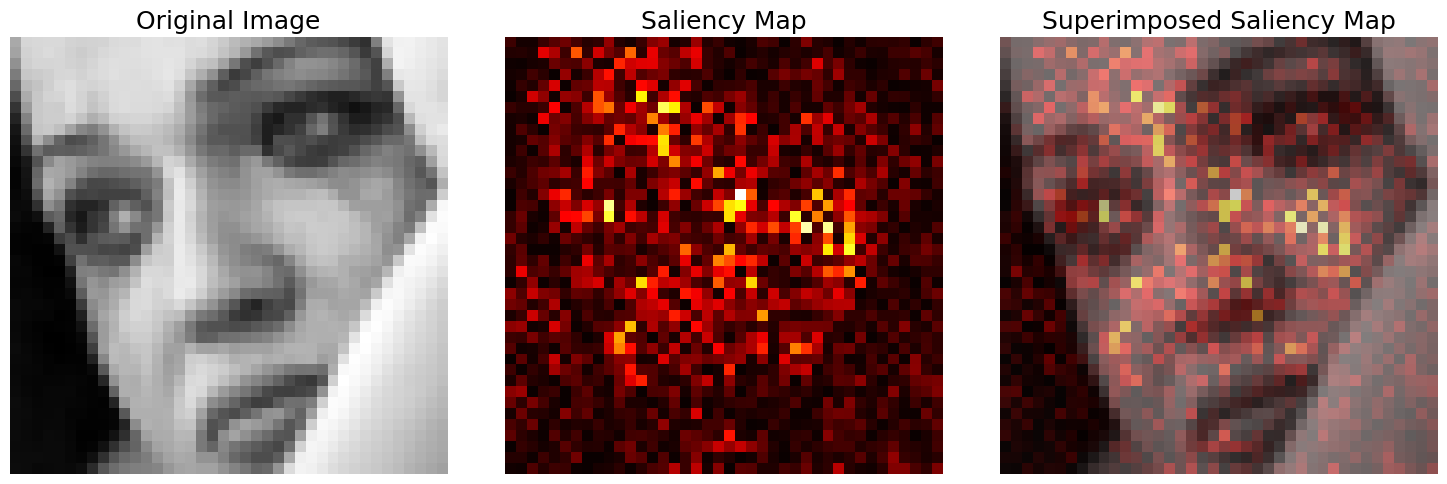

In [24]:
def generate_saliency_maps(hps_args):
    # Load a trained model
    hps = setup_hparams(hps_args)
    logger, net = setup_network(hps)
    net.eval()
    net = net.to(device) # Move the network to the device (GPU)

    # Get a single image
    # Note: Saliency map notebook uses a different transform
    saliency_transform = transforms.Compose([
        transforms.Resize(40),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0,), std=(255,))
    ])

    fer2013, _ = fer2013_load_data() # This loads the data
    # Clean column names to avoid issues with leading/trailing spaces
    fer2013.columns = fer2013.columns.str.strip()

    # Filter for training data using the cleaned column name
    training_data = fer2013[fer2013['Usage'] == 'Training']

    # Prepare the training data using fer2013_prepare_data
    xtrain, ytrain = fer2013_prepare_data(training_data)

    saliency_dataset = CustomDataset(xtrain, ytrain, saliency_transform)
    saliency_loader = DataLoader(saliency_dataset, batch_size=1, shuffle=True)

    image, label = next(iter(saliency_loader))
    image_for_plot = image.squeeze().numpy()

    image = image.to(device)
    image.requires_grad_()

    output = net(image)
    prediction = output.argmax()
    output_max = output[0, prediction]
    output_max.backward()

    saliency, _ = torch.max(image.grad.data.abs(), dim=1)
    saliency = saliency.reshape(40, 40)

    # Move saliency map to CPU for plotting
    saliency_cpu = saliency.cpu()

    # Rescale for visualization
    saliency_cpu -= saliency_cpu.min()
    saliency_cpu /= saliency_cpu.max()

    print(f"Ground Truth: {label.item()}, Prediction: {prediction.item()}")

    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    plt.tight_layout()

    axs[0].set_title('Original Image', fontsize=18)
    axs[0].imshow(image_for_plot, cmap='gray')
    axs[0].axis('off')

    axs[1].set_title('Saliency Map', fontsize=18)
    im = axs[1].imshow(saliency_cpu, cmap='hot')
    axs[1].axis('off')

    axs[2].set_title('Superimposed Saliency Map', fontsize=18)
    axs[2].imshow(image_for_plot, cmap='gray')
    axs[2].imshow(saliency_cpu, cmap='hot', alpha=0.5)
    axs[2].axis('off')

    plt.show()

hps_args_saliency = ['network=vgg', 'name=my_vgg_run', 'restore_epoch=100']
generate_saliency_maps(hps_args_saliency)